In [1]:
%reset
import os

# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')

import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2




In [2]:
from colossus.cosmology import cosmology
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
cosmo = cosmology.setCosmology('myCosmo', **cosmo_params_dict)
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['theta_co'] = 0.1
sim_params_dict['theta_ej'] = 4.0
sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['M1_starcga'] = 2.5e11
sim_params_dict['epsilon_rt'] = 4.0
sim_params_dict['Mc0'] = 10**14.83
# sim_params_dict['Mc0'] = 10**1
sim_params_dict['nu_z'] = 0
sim_params_dict['nu_M'] = 0
sim_params_dict['Mstar0'] = 10**13
sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict
sim_params_dict['beam_fwhm_arcmin'] = 1.6



In [3]:
2**15

32768

In [4]:
halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 10, 64
halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.01, 2.5, 32
halo_params_dict['Mmin'], halo_params_dict['Mmax'], halo_params_dict['nM'] = 1e12, 1e15, 32
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 10, 32
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**16, 512
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.25
halo_params_dict['mdef'] = '200c'




In [5]:
from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-3)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-3)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-3)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-3)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['compton_shear'].data['ANG'][0:20]


analysis_dict['angles_data_array'] = jnp.array(theta_data)



In [6]:
# %%time
# BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)


gpu


In [9]:
from get_BCMP_profile_jit import BCM_18_wP



In [10]:
BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)



OverflowError: An overflow was encountered while parsing an argument to a jitted computation, whose argument path is x2.

/tmp/ipykernel_1391296/2525561178.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
100%|██████████| 32/32 [00:00<00:00, 64.64it/s]
/tmp/ipykernel_1391296/2525561178.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = pl.colorbar(sm)


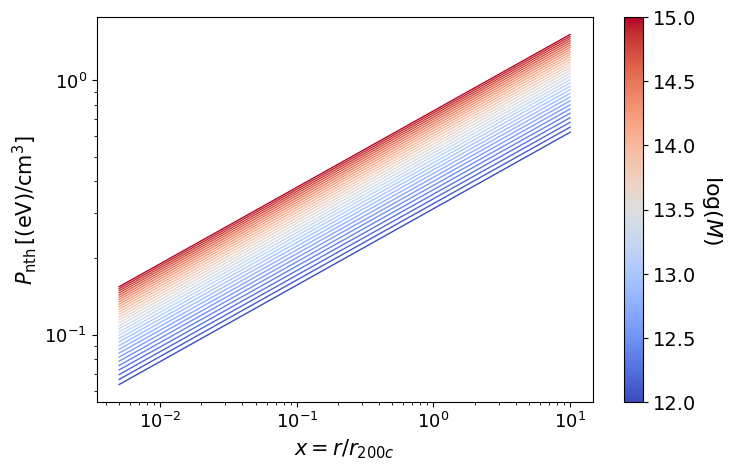

In [ ]:
# plot the lines for different halo masses with a color map for each mass
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# R500c
from tqdm import tqdm
pl.figure(figsize=(8,5))
Mc0_arr = np.log10(BCMP_test.M200c_array)

# create a color map
cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
norm = Normalize(vmin=(Mc0_arr).min(), vmax=(Mc0_arr).max())

for jM in tqdm(range(len(Mc0_arr))):
    color = cmap(norm((Mc0_arr[jM])))
    # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[jM,0], BCMP_test.Pth_mat[:,4,0,jM], color=color, alpha=1.0,lw=1.0)
    pl.plot(BCMP_test.r_array, BCMP_test.Pnt_fac[:,5,0,jM], color=color, alpha=1.0,lw=1.0)
    
    
# rho3 = Battaglia_12_16(M200c, zv, cosmo)
# pl.plot(r_array/r200c, ((r_array/r200c)**2)*rho_gas_KS, label = 'KS01', ls='--', color='k',lw=2.0)
# pl.plot(r_array/r200c, rho3.fb * ((r_array/r200c)**2)*rho_gas_B16, label = 'B16', ls=':', color='k',lw=2.0)

pl.xscale('log')
pl.yscale('log')
pl.tick_params(axis='both', which='major', labelsize=13)
pl.xlabel(r'$x = r/r_{200c}$', fontsize=15)
# pl.ylabel(r'$x^2 \rho_{gas}$', fontsize=15)
pl.ylabel(r'$P_{\rm nth} \, [({\rm eV})/{\rm cm}^3]$', fontsize=15)
# pl.title(r'$\theta_{\rm ej} = $' + str(theta_ej) + ',' + r'$M = $' + str(np.round(np.log10(M200c), 2)), fontsize=15)
# pl.legend(fontsize=14)

# create a ScalarMappable with the colormap and norm
sm = ScalarMappable(cmap=cmap, norm=norm)
# the array is not used in this case, but normally the values used for the colormap are passed here
sm.set_array([])
# add the colorbar to the figure
cbar = pl.colorbar(sm)
cbar.set_label(r'$\log(M)$', fontsize=16, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=14)






In [4]:
import numpy as np
# np.log10((10** 11.91) *0.6737)
np.log10((10** 13.42) *0.6737)




13.248466547352677

/tmp/ipykernel_1391296/2095292645.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
100%|██████████| 32/32 [00:00<00:00, 131.24it/s]
/tmp/ipykernel_1391296/2095292645.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = pl.colorbar(sm)


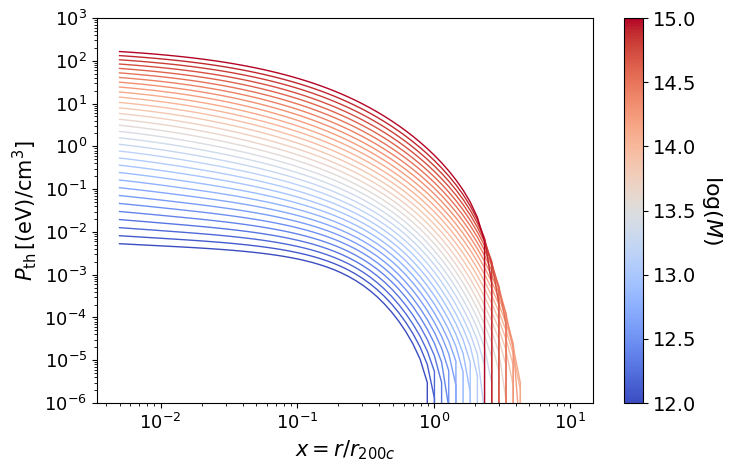

In [27]:
# plot the lines for different halo masses with a color map for each mass
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# R500c
from tqdm import tqdm
pl.figure(figsize=(8,5))
Mc0_arr = np.log10(BCMP_test.M200c_array)

# create a color map
cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
norm = Normalize(vmin=(Mc0_arr).min(), vmax=(Mc0_arr).max())

for jM in tqdm(range(len(Mc0_arr))):
    color = cmap(norm((Mc0_arr[jM])))
    # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[jM,0], BCMP_test.Pth_mat[:,4,0,jM], color=color, alpha=1.0,lw=1.0)
    pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,5,0,jM], color=color, alpha=1.0,lw=1.0)
    
    
# rho3 = Battaglia_12_16(M200c, zv, cosmo)
# pl.plot(r_array/r200c, ((r_array/r200c)**2)*rho_gas_KS, label = 'KS01', ls='--', color='k',lw=2.0)
# pl.plot(r_array/r200c, rho3.fb * ((r_array/r200c)**2)*rho_gas_B16, label = 'B16', ls=':', color='k',lw=2.0)

pl.xscale('log')
pl.yscale('log')
pl.tick_params(axis='both', which='major', labelsize=13)
pl.xlabel(r'$x = r/r_{200c}$', fontsize=15)
# pl.ylabel(r'$x^2 \rho_{gas}$', fontsize=15)
pl.ylabel(r'$P_{\rm th} \, [({\rm eV})/{\rm cm}^3]$', fontsize=15)
# pl.title(r'$\theta_{\rm ej} = $' + str(theta_ej) + ',' + r'$M = $' + str(np.round(np.log10(M200c), 2)), fontsize=15)
# pl.legend(fontsize=14)
pl.ylim(1e-6, 1e3)
# create a ScalarMappable with the colormap and norm
sm = ScalarMappable(cmap=cmap, norm=norm)
# the array is not used in this case, but normally the values used for the colormap are passed here
sm.set_array([])
# add the colorbar to the figure
cbar = pl.colorbar(sm)
cbar.set_label(r'$\log(M)$', fontsize=16, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=14)






/tmp/ipykernel_1391296/1239587756.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
100%|██████████| 32/32 [00:00<00:00, 130.99it/s]
/tmp/ipykernel_1391296/1239587756.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = pl.colorbar(sm)


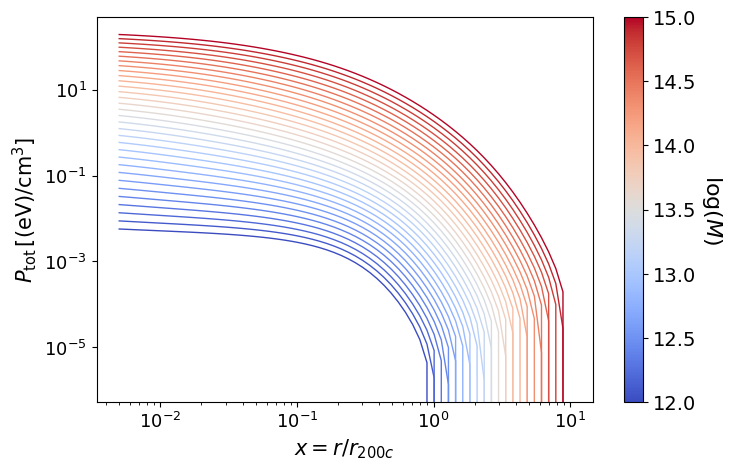

In [15]:
# plot the lines for different halo masses with a color map for each mass
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# R500c
from tqdm import tqdm
pl.figure(figsize=(8,5))
Mc0_arr = np.log10(BCMP_test.M200c_array)

# create a color map
cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
norm = Normalize(vmin=(Mc0_arr).min(), vmax=(Mc0_arr).max())

for jM in tqdm(range(len(Mc0_arr))):
    color = cmap(norm((Mc0_arr[jM])))
    # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[jM,0], BCMP_test.Pth_mat[:,4,0,jM], color=color, alpha=1.0,lw=1.0)
    pl.plot(BCMP_test.r_array, BCMP_test.Ptot_mat[:,5,0,jM], color=color, alpha=1.0,lw=1.0)
    
    
# rho3 = Battaglia_12_16(M200c, zv, cosmo)
# pl.plot(r_array/r200c, ((r_array/r200c)**2)*rho_gas_KS, label = 'KS01', ls='--', color='k',lw=2.0)
# pl.plot(r_array/r200c, rho3.fb * ((r_array/r200c)**2)*rho_gas_B16, label = 'B16', ls=':', color='k',lw=2.0)

pl.xscale('log')
pl.yscale('log')
pl.tick_params(axis='both', which='major', labelsize=13)
pl.xlabel(r'$x = r/r_{200c}$', fontsize=15)
# pl.ylabel(r'$x^2 \rho_{gas}$', fontsize=15)
pl.ylabel(r'$P_{\rm tot} \, [({\rm eV})/{\rm cm}^3]$', fontsize=15)
# pl.title(r'$\theta_{\rm ej} = $' + str(theta_ej) + ',' + r'$M = $' + str(np.round(np.log10(M200c), 2)), fontsize=15)
# pl.legend(fontsize=14)

# create a ScalarMappable with the colormap and norm
sm = ScalarMappable(cmap=cmap, norm=norm)
# the array is not used in this case, but normally the values used for the colormap are passed here
sm.set_array([])
# add the colorbar to the figure
cbar = pl.colorbar(sm)
cbar.set_label(r'$\log(M)$', fontsize=16, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=14)






In [32]:
from get_B12_profile import Battaglia_12_16

M200_arr = np.log10(BCMP_test.M200c_array)
Pth_mat_B12 = np.zeros((len(M200_arr), len(BCMP_test.r_array)))
for jM in tqdm(range(len(M200_arr))):
    B12_obj_jM = Battaglia_12_16(10**M200_arr[jM], 0.0, cosmo=cosmo)
    Pth_B12_jM = B12_obj_jM.get_Pth(BCMP_test.r_array)
    Pth_mat_B12[jM, :] = Pth_B12_jM
    
    


100%|██████████| 32/32 [00:00<00:00, 1139.93it/s]


/tmp/ipykernel_1391296/3246506153.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
100%|██████████| 32/32 [00:00<00:00, 288.67it/s]
/tmp/ipykernel_1391296/3246506153.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = pl.colorbar(sm)


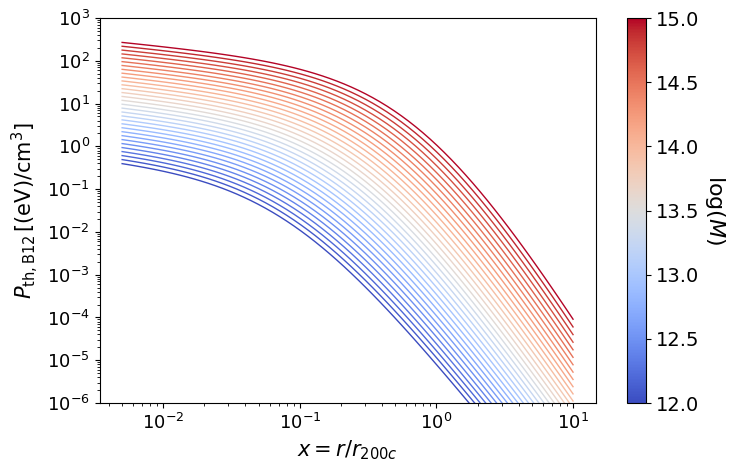

In [33]:
# plot the lines for different halo masses with a color map for each mass
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# R500c
from tqdm import tqdm
pl.figure(figsize=(8,5))
Mc0_arr = np.log10(BCMP_test.M200c_array)

# create a color map
cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
norm = Normalize(vmin=(Mc0_arr).min(), vmax=(Mc0_arr).max())

for jM in tqdm(range(len(Mc0_arr))):
    color = cmap(norm((Mc0_arr[jM])))
    # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[jM,0], BCMP_test.Pth_mat[:,4,0,jM], color=color, alpha=1.0,lw=1.0)
    pl.plot(BCMP_test.r_array, Pth_mat_B12[jM,:], color=color, alpha=1.0,lw=1.0)
    
    
# rho3 = Battaglia_12_16(M200c, zv, cosmo)
# pl.plot(r_array/r200c, ((r_array/r200c)**2)*rho_gas_KS, label = 'KS01', ls='--', color='k',lw=2.0)
# pl.plot(r_array/r200c, rho3.fb * ((r_array/r200c)**2)*rho_gas_B16, label = 'B16', ls=':', color='k',lw=2.0)

pl.xscale('log')
pl.yscale('log')
pl.tick_params(axis='both', which='major', labelsize=13)
pl.xlabel(r'$x = r/r_{200c}$', fontsize=15)
# pl.ylabel(r'$x^2 \rho_{gas}$', fontsize=15)
pl.ylabel(r'$P_{\rm th, B12} \, [({\rm eV})/{\rm cm}^3]$', fontsize=15)
# pl.title(r'$\theta_{\rm ej} = $' + str(theta_ej) + ',' + r'$M = $' + str(np.round(np.log10(M200c), 2)), fontsize=15)
# pl.legend(fontsize=14)
pl.ylim(1e-6,1e3)
# create a ScalarMappable with the colormap and norm
sm = ScalarMappable(cmap=cmap, norm=norm)
# the array is not used in this case, but normally the values used for the colormap are passed here
sm.set_array([])
# add the colorbar to the figure
cbar = pl.colorbar(sm)
cbar.set_label(r'$\log(M)$', fontsize=16, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=14)






/tmp/ipykernel_1350471/3684892926.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
100%|██████████| 32/32 [00:00<00:00, 129.22it/s]
/tmp/ipykernel_1350471/3684892926.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = pl.colorbar(sm)


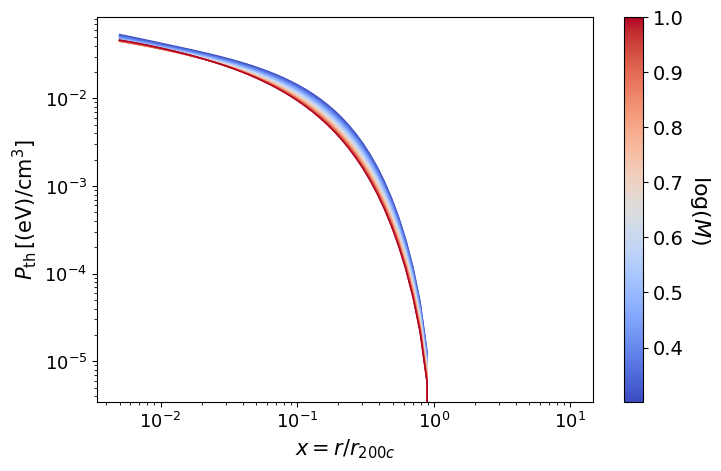

In [21]:
# plot the lines for different halo masses with a color map for each mass
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# R500c
from tqdm import tqdm
pl.figure(figsize=(8,5))
Mc0_arr = np.log10(BCMP_test.conc_array)

# create a color map
cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
norm = Normalize(vmin=(Mc0_arr).min(), vmax=(Mc0_arr).max())

for jM in tqdm(range(len(Mc0_arr))):
    color = cmap(norm((Mc0_arr[jM])))
    # pl.plot(BCMP_test.r_array/BCMP_test.r200c_mat[jM,0], BCMP_test.Pth_mat[:,4,0,jM], color=color, alpha=1.0,lw=1.0)
    pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,jM,0,5], color=color, alpha=1.0,lw=1.0)
    
    
# rho3 = Battaglia_12_16(M200c, zv, cosmo)
# pl.plot(r_array/r200c, ((r_array/r200c)**2)*rho_gas_KS, label = 'KS01', ls='--', color='k',lw=2.0)
# pl.plot(r_array/r200c, rho3.fb * ((r_array/r200c)**2)*rho_gas_B16, label = 'B16', ls=':', color='k',lw=2.0)

pl.xscale('log')
pl.yscale('log')
pl.tick_params(axis='both', which='major', labelsize=13)
pl.xlabel(r'$x = r/r_{200c}$', fontsize=15)
# pl.ylabel(r'$x^2 \rho_{gas}$', fontsize=15)
pl.ylabel(r'$P_{\rm th} \, [({\rm eV})/{\rm cm}^3]$', fontsize=15)
# pl.title(r'$\theta_{\rm ej} = $' + str(theta_ej) + ',' + r'$M = $' + str(np.round(np.log10(M200c), 2)), fontsize=15)
# pl.legend(fontsize=14)

# create a ScalarMappable with the colormap and norm
sm = ScalarMappable(cmap=cmap, norm=norm)
# the array is not used in this case, but normally the values used for the colormap are passed here
sm.set_array([])
# add the colorbar to the figure
cbar = pl.colorbar(sm)
cbar.set_label(r'$\log(M)$', fontsize=16, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=14)






Text(0, 0.5, '$P_{\\rm th} \\, [({\\rm eV})/{\\rm cm}^3]$')

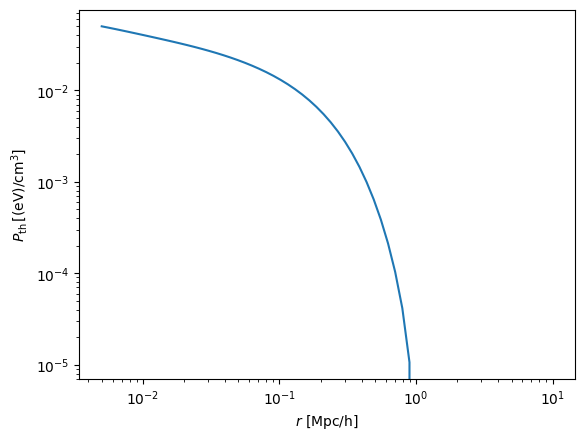

In [16]:
# plot the lines for different halo masses with a color map for each mass

pl.figure()
for ji in range(10):
    pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,4,0,5])
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$r$ [Mpc/h]')
pl.ylabel(r'$P_{\rm th} \, [({\rm eV})/{\rm cm}^3]$')


In [11]:
from setup_power_spectra_jit import setup_power_BCMP

setup_power_BCMP_test = setup_power_BCMP(sim_params_dict, halo_params_dict, num_points_trapz_int=64)

Pk_nfw = setup_power_BCMP_test.plin_kz_mat[:,0] + setup_power_BCMP_test.Pmm_nfw_1h_mat[:,0]
Pk_dmb = setup_power_BCMP_test.plin_kz_mat[:,0] + setup_power_BCMP_test.Pmm_dmb_1h_mat[:,0]
Pk_sup = (Pk_dmb)/Pk_nfw



In [12]:
len(Pk_sup)

64

In [13]:
from setup_power_spectra_jit import setup_power_BCMP
from tqdm import tqdm
import copy
sims_params_dict_vary = copy.deepcopy(sim_params_dict)
theta_ej_array = np.linspace(1.0, 6.0, 10)
Pk_sup_all = np.zeros((len(theta_ej_array), len(Pk_sup)))
for jt in tqdm(range(len(theta_ej_array))):
    sims_params_dict_vary['theta_ej'] = theta_ej_array[jt]
    setup_power_BCMP_test = setup_power_BCMP(sims_params_dict_vary, halo_params_dict, num_points_trapz_int=64)
    Pk_nfw = setup_power_BCMP_test.plin_kz_mat[:,0] + setup_power_BCMP_test.Pmm_nfw_1h_mat[:,0]
    Pk_dmb = setup_power_BCMP_test.plin_kz_mat[:,0] + setup_power_BCMP_test.Pmm_dmb_1h_mat[:,0]
    Pk_sup = (Pk_dmb)/Pk_nfw
    Pk_sup_all[jt,:] = Pk_sup



  0%|          | 0/10 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [14]:
# from get_corr_func import get_corrfunc_BCMP
import copy
from tqdm import tqdm
from get_corr_func_jit import get_corrfunc_BCMP
sims_params_dict_vary = copy.deepcopy(sim_params_dict)
theta_ej_array = np.linspace(1.0, 6.0, 10)
analysis_dict_vary = copy.deepcopy(analysis_dict)
gty_out_all = np.zeros((len(theta_ej_array), len(theta_data)))
xip_out_all = np.zeros((len(theta_ej_array), len(theta_data)))
xim_out_all = np.zeros((len(theta_ej_array), len(theta_data)))
for jt in tqdm(range(len(theta_ej_array))):
    sims_params_dict_vary['theta_ej'] = theta_ej_array[jt]
    analysis_dict_vary['angles_data_array'] = jnp.logspace(np.log10(0.5), np.log10(100), len(theta_data))
    get_corrfunc_BCMP_test = get_corrfunc_BCMP(sims_params_dict_vary, halo_params_dict, analysis_dict_vary, verbose_time=False)
    gty_out_all[jt,:] = get_corrfunc_BCMP_test.gty_out_mat[:,3]
    xip_out_all[jt,:] = get_corrfunc_BCMP_test.xip_out_mat[:,3,3]
    xim_out_all[jt,:] = get_corrfunc_BCMP_test.xim_out_mat[:,3,3]
    





100%|██████████| 10/10 [03:50<00:00, 23.08s/it]


In [15]:
analysis_dict_vary['angles_data_array']

Array([  0.5       ,   0.66081036,   0.87334068,   1.15422514,
         1.52544787,   2.01606353,   2.66447135,   3.52142058,
         4.65398243,   6.15079965,   8.12902432,  10.74348706,
        14.1988152 ,  18.7654485 ,  24.80080574,  32.77725897,
        43.31910491,  57.25142703,  75.66467276, 100.        ],      dtype=float64)

/tmp/ipykernel_528931/3943075255.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
100%|██████████| 10/10 [00:00<00:00, 368.18it/s]
/tmp/ipykernel_528931/3943075255.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = pl.colorbar(sm)


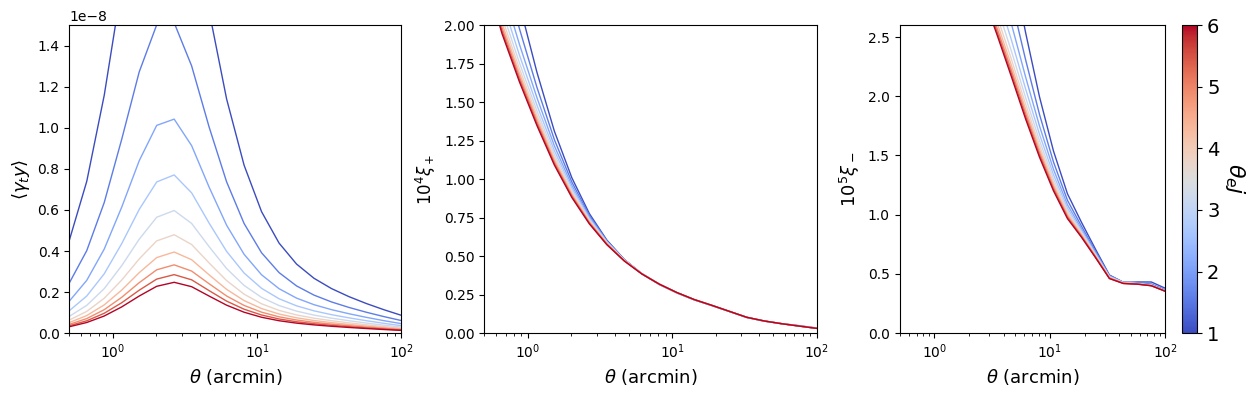

In [16]:
# make a three panel plot, plotting all the theta_ej curves for for gty_out_thetaej[:,3,:], xip_out_thetaej[:,3,3,:], xim_out_thetaej[:,3,3,:]
# draw theta_ej curves from a colormap
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
norm = Normalize(vmin=(theta_ej_array).min(), vmax=(theta_ej_array).max())
analysis_dict_vary['angles_data_array'] = jnp.logspace(np.log10(0.5), np.log10(100), len(theta_data))

pl.figure(figsize=(15,4))
# increase the distance between subplots:
pl.subplots_adjust(wspace=0.25)
pl.subplot(131)
for jM in tqdm(range(len(theta_ej_array))):
    color = cmap(norm((theta_ej_array[jM])))
    pl.plot(analysis_dict_vary['angles_data_array'], gty_out_all[jM,:], color=color, alpha=1.0,lw=1.0)
# pl.legend()
pl.xscale('log')
pl.xlim(0.5,100)
pl.ylim(0.0,1.5e-8)
pl.ylabel(r'$\langle \gamma_t y \rangle$', fontsize=13)
pl.xlabel(r'$\theta$ (arcmin)', fontsize=13)
# pl.title('1-halo term')
pl.subplot(132)
for jM in tqdm(range(len(theta_ej_array))):
    color = cmap(norm((theta_ej_array[jM])))
    pl.plot(analysis_dict_vary['angles_data_array'], 1e4*xip_out_all[jM,:], color=color, alpha=1.0,lw=1.0)

# pl.legend()
pl.xscale('log')
pl.xlim(0.5,100)
pl.ylim(0.0,2)
pl.ylabel(r'$10^4 \xi_+$', fontsize=12)
pl.xlabel(r'$\theta$ (arcmin)', fontsize=13)
# pl.title('2-halo term')
pl.subplot(133)
for jM in tqdm(range(len(theta_ej_array))):
    color = cmap(norm((theta_ej_array[jM])))
    pl.plot(analysis_dict_vary['angles_data_array'], 1e5*xim_out_all[jM,:], color=color, alpha=1.0,lw=1.0)

# pl.legend()
# pl.legend()
pl.xscale('log')
pl.xlim(0.5,100)
pl.ylim(0.0,2.6)
pl.ylabel(r'$10^5 \xi_-$', fontsize=13)
pl.xlabel(r'$\theta$ (arcmin)', fontsize=13)
# pl.title('2-halo term')

# create a ScalarMappable with the colormap and norm
sm = ScalarMappable(cmap=cmap, norm=norm)
# the array is not used in this case, but normally the values used for the colormap are passed here
sm.set_array([])
# add the colorbar to the figure
cbar = pl.colorbar(sm)
cbar.set_label(r'$\theta_ej$', fontsize=16, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=14)






/tmp/ipykernel_189042/3294486978.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
100%|██████████| 10/10 [00:00<00:00, 171.84it/s]
/tmp/ipykernel_189042/3294486978.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = pl.colorbar(sm)


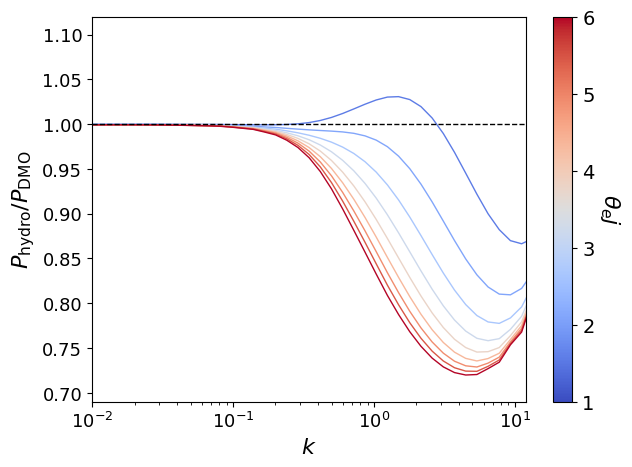

In [25]:
# plot the lines for different halo masses with a color map for each mass
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# R500c
from tqdm import tqdm
pl.figure(figsize=(7,5))
# Mc0_arr = np.log10(BCMP_test.conc_array)

# create a color map
cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
norm = Normalize(vmin=(theta_ej_array).min(), vmax=(theta_ej_array).max())

for jM in tqdm(range(len(theta_ej_array))):
    if jM > 0:
        color = cmap(norm((theta_ej_array[jM])))
        pl.plot(setup_power_BCMP_test.kPk_array, Pk_sup_all[jM,:], color=color, alpha=1.0,lw=1.0)
pl.axhline(y=1.0, color='k', ls='--', lw=1.0)
pl.xscale('log')
# pl.yscale('log')
pl.tick_params(axis='both', which='major', labelsize=13)
pl.xlim(1e-2, 12)
pl.xlabel(r'$k$', fontsize=16)
pl.ylabel(r'$P_{\rm hydro}/P_{\rm DMO}$', fontsize=16)
pl.ylim(0.69,1.12)

# create a ScalarMappable with the colormap and norm
sm = ScalarMappable(cmap=cmap, norm=norm)
# the array is not used in this case, but normally the values used for the colormap are passed here
sm.set_array([])
# add the colorbar to the figure
cbar = pl.colorbar(sm)
cbar.set_label(r'$\theta_ej$', fontsize=16, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=14)






In [9]:
from setup_power_spectra_jit import setup_power_BCMP
from tqdm import tqdm
import copy
sims_params_dict_vary = copy.deepcopy(sim_params_dict)
theta_co_array = np.linspace(0.01, 0.5, 15)
Pk_sup_all_thetaco = np.zeros((len(theta_co_array), len(Pk_sup)))
for jt in tqdm(range(len(theta_co_array))):
    sims_params_dict_vary['theta_co'] = theta_co_array[jt]
    setup_power_BCMP_test = setup_power_BCMP(sims_params_dict_vary, halo_params_dict, num_points_trapz_int=64)
    Pk_nfw = setup_power_BCMP_test.plin_kz_mat[:,0] + setup_power_BCMP_test.Pmm_nfw_1h_mat[:,0]
    Pk_dmb = setup_power_BCMP_test.plin_kz_mat[:,0] + setup_power_BCMP_test.Pmm_dmb_1h_mat[:,0]
    Pk_sup = (Pk_dmb)/Pk_nfw
    Pk_sup_all_thetaco[jt,:] = Pk_sup




100%|██████████| 15/15 [04:37<00:00, 18.48s/it]


/tmp/ipykernel_1349993/1974414609.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
100%|██████████| 15/15 [00:00<00:00, 55.10it/s]
/tmp/ipykernel_1349993/1974414609.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = pl.colorbar(sm)


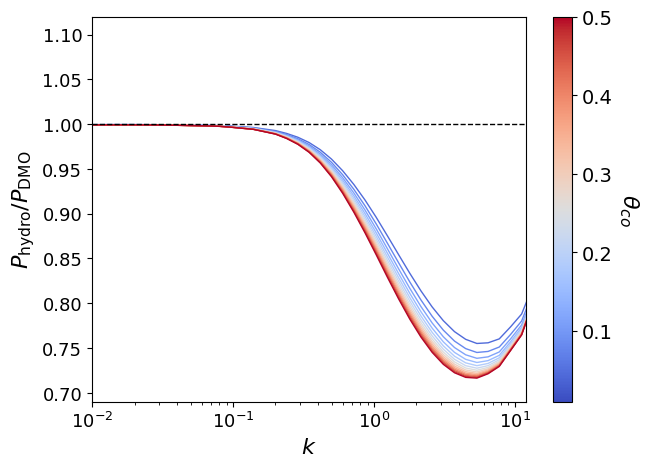

In [12]:
# plot the lines for different halo masses with a color map for each mass
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# R500c
from tqdm import tqdm
pl.figure(figsize=(7,5))
# Mc0_arr = np.log10(BCMP_test.conc_array)

# create a color map
cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
norm = Normalize(vmin=(theta_co_array).min(), vmax=(theta_co_array).max())

for jM in tqdm(range(len(theta_co_array))):
    if jM > 0:
        color = cmap(norm((theta_co_array[jM])))
        pl.plot(setup_power_BCMP_test.kPk_array, Pk_sup_all_thetaco[jM,:], color=color, alpha=1.0,lw=1.0)
pl.axhline(y=1.0, color='k', ls='--', lw=1.0)
pl.xscale('log')
# pl.yscale('log')
pl.tick_params(axis='both', which='major', labelsize=13)
pl.xlim(1e-2, 12)
pl.xlabel(r'$k$', fontsize=16)
pl.ylabel(r'$P_{\rm hydro}/P_{\rm DMO}$', fontsize=16)
pl.ylim(0.69,1.12)

# create a ScalarMappable with the colormap and norm
sm = ScalarMappable(cmap=cmap, norm=norm)
# the array is not used in this case, but normally the values used for the colormap are passed here
sm.set_array([])
# add the colorbar to the figure
cbar = pl.colorbar(sm)
cbar.set_label(r'$\theta_{co}$', fontsize=16, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=14)








In [14]:
# from get_corr_func import get_corrfunc_BCMP
import copy
from tqdm import tqdm
from get_corr_func_jit import get_corrfunc_BCMP
sims_params_dict_vary = copy.deepcopy(sim_params_dict)
analysis_dict_vary = copy.deepcopy(analysis_dict)
gty_out_all_thetaco = np.zeros((len(theta_co_array), len(theta_data)))
xip_out_all_thetaco = np.zeros((len(theta_co_array), len(theta_data)))
xim_out_all_thetaco = np.zeros((len(theta_co_array), len(theta_data)))
for jt in tqdm(range(len(theta_co_array))):
    sims_params_dict_vary['theta_co'] = theta_co_array[jt]
    analysis_dict_vary['angles_data_array'] = jnp.logspace(np.log10(0.5), np.log10(100), len(theta_data))
    get_corrfunc_BCMP_test = get_corrfunc_BCMP(sims_params_dict_vary, halo_params_dict, analysis_dict_vary, verbose_time=False)
    gty_out_all_thetaco[jt,:] = get_corrfunc_BCMP_test.gty_out_mat[:,3]
    xip_out_all_thetaco[jt,:] = get_corrfunc_BCMP_test.xip_out_mat[:,3,3]
    xim_out_all_thetaco[jt,:] = get_corrfunc_BCMP_test.xim_out_mat[:,3,3]
    





 93%|█████████▎| 14/15 [05:27<00:23, 23.33s/it]2023-08-16 15:33:23.686379: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.99GiB (rounded to 6426758144)requested by op 
2023-08-16 15:33:23.687406: W external/tsl/tsl/framework/bfc_allocator.cc:497] **********************************************************************************__________________
2023-08-16 15:33:23.687577: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2461] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6426757936 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:     1.2KiB
              constant allocation:   809.3KiB
        maybe_live_out allocation:   16.00MiB
     preallocated temp allocation:    5.99GiB
  preallocated temp fragmentation:         8B (0.00%)
                 total allocation:    6.00GiB
              total fragmentation:   16.30MiB (0.2

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6426757936 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:     1.2KiB
              constant allocation:   809.3KiB
        maybe_live_out allocation:   16.00MiB
     preallocated temp allocation:    5.99GiB
  preallocated temp fragmentation:         8B (0.00%)
                 total allocation:    6.00GiB
              total fragmentation:   16.30MiB (0.27%)
Peak buffers:
	Buffer 1:
		Size: 1.00GiB
		Operator: op_name="jit(get_zeta)/jit(main)/vmap(jit(get_Mgas))/vmap(jit(get_rho_gas_normed))/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=357
		XLA Label: fusion
		Shape: f64[1,32,32,64,32,64]
		==========================

	Buffer 2:
		Size: 1.00GiB
		Operator: op_name="jit(get_zeta)/jit(main)/vmap(jit(get_Mgas))/vmap(jit(get_rho_gas_normed))/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=357
		XLA Label: fusion
		Shape: f64[1,32,32,64,32,64]
		==========================

	Buffer 3:
		Size: 1.00GiB
		Operator: op_name="jit(get_zeta)/jit(main)/vmap(jit(get_Mcga))/mul" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=182
		XLA Label: fusion
		Shape: f64[32,32,64,32,64]
		==========================

	Buffer 4:
		Size: 1.00GiB
		Operator: op_name="jit(get_zeta)/jit(main)/vmap(jit(get_Mcga))/mul" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=182
		XLA Label: fusion
		Shape: f64[32,32,64,32,64]
		==========================

	Buffer 5:
		Size: 1008.00MiB
		Operator: op_name="jit(get_zeta)/jit(main)/vmap(jit(get_Mcga))/jit(trapz)/jit(diff)/sub" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=183
		XLA Label: fusion
		Shape: f64[32,32,64,32,63]
		==========================

	Buffer 6:
		Size: 512.00MiB
		Operator: op_name="jit(get_zeta)/jit(main)/vmap(jit(get_Mcga))/jit(trapz)/reduce_sum[axes=(5,)]" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=183
		XLA Label: fusion
		Shape: f64[32,32,32,64,32]
		==========================

	Buffer 7:
		Size: 512.00MiB
		Operator: op_name="jit(get_zeta)/jit(main)/vmap(jit(get_Mcga))/jit(trapz)/reduce_sum[axes=(5,)]" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=183
		XLA Label: fusion
		Shape: f64[32,32,32,64,32]
		==========================

	Buffer 8:
		Size: 16.00MiB
		Operator: op_name="jit(get_zeta)/jit(main)/jit(_interp)/jit(_where)/select_n" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=400
		XLA Label: fusion
		Shape: f64[32,32,32,64]
		==========================

	Buffer 9:
		Size: 256.0KiB
		Operator: op_name="jit(get_zeta)/jit(main)/jit(get_Mnfw)/vmap(jit(get_rho_nfw_normed))/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=250
		XLA Label: fusion
		Shape: f64[32768,1,1,1]
		==========================

	Buffer 10:
		Size: 256.0KiB
		Operator: op_name="jit(get_zeta)/jit(main)/jit(get_Mnfw)/vmap(jit(get_rho_nfw_normed))/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=250
		XLA Label: fusion
		Shape: f64[32768,1,1,1]
		==========================

	Buffer 11:
		Size: 256.0KiB
		Operator: op_name="jit(get_zeta)/jit(main)/jit(get_Mnfw)/vmap(jit(get_rho_nfw_normed))/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=250
		XLA Label: fusion
		Shape: f64[32768,1,1,1]
		==========================

	Buffer 12:
		Size: 256.0KiB
		Operator: op_name="jit(get_zeta)/jit(main)/jit(get_Mnfw)/vmap(jit(get_rho_nfw_normed))/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=250
		XLA Label: fusion
		Shape: f64[32,32,32]
		==========================

	Buffer 13:
		Size: 256.0KiB
		XLA Label: constant
		Shape: f64[32,32,32]
		==========================

	Buffer 14:
		Size: 256.0KiB
		XLA Label: constant
		Shape: f64[32,32,32]
		==========================

	Buffer 15:
		Size: 256.0KiB
		XLA Label: constant
		Shape: f64[32,32,32]
		==========================



/tmp/ipykernel_1349993/1827260415.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
100%|██████████| 15/15 [00:00<00:00, 370.21it/s]
/tmp/ipykernel_1349993/1827260415.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = pl.colorbar(sm)


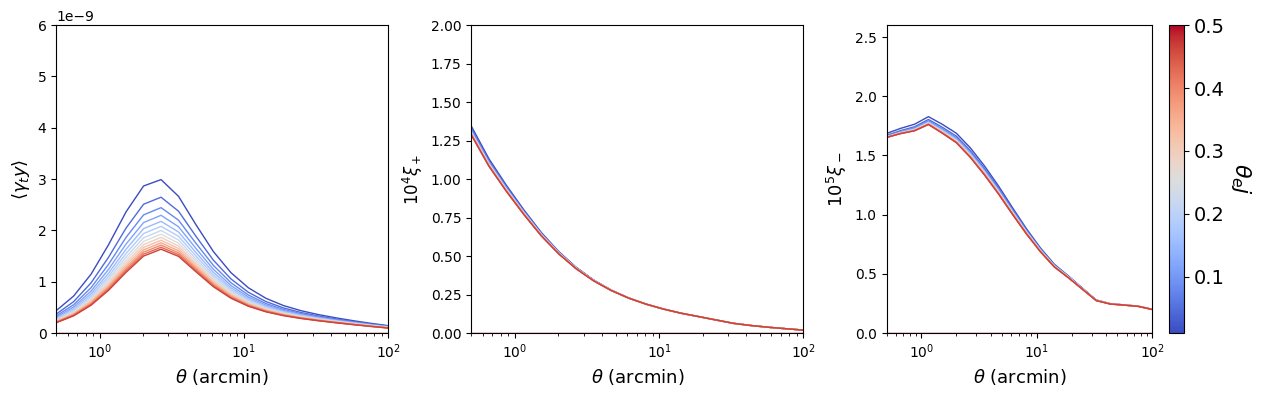

In [16]:
# make a three panel plot, plotting all the theta_ej curves for for gty_out_thetaej[:,3,:], xip_out_thetaej[:,3,3,:], xim_out_thetaej[:,3,3,:]
# draw theta_ej curves from a colormap
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
norm = Normalize(vmin=(theta_co_array).min(), vmax=(theta_co_array).max())
analysis_dict_vary['angles_data_array'] = jnp.logspace(np.log10(0.5), np.log10(100), len(theta_data))

pl.figure(figsize=(15,4))
# increase the distance between subplots:
pl.subplots_adjust(wspace=0.25)
pl.subplot(131)
for jM in tqdm(range(len(theta_co_array))):
    color = cmap(norm((theta_co_array[jM])))
    pl.plot(analysis_dict_vary['angles_data_array'], gty_out_all_thetaco[jM,:], color=color, alpha=1.0,lw=1.0)
# pl.legend()
pl.xscale('log')
pl.xlim(0.5,100)
pl.ylim(0.0,0.6e-8)
pl.ylabel(r'$\langle \gamma_t y \rangle$', fontsize=13)
pl.xlabel(r'$\theta$ (arcmin)', fontsize=13)
# pl.title('1-halo term')
pl.subplot(132)
for jM in tqdm(range(len(theta_co_array))):
    color = cmap(norm((theta_co_array[jM])))
    pl.plot(analysis_dict_vary['angles_data_array'], 1e4*xip_out_all_thetaco[jM,:], color=color, alpha=1.0,lw=1.0)

# pl.legend()
pl.xscale('log')
pl.xlim(0.5,100)
pl.ylim(0.0,2)
pl.ylabel(r'$10^4 \xi_+$', fontsize=12)
pl.xlabel(r'$\theta$ (arcmin)', fontsize=13)
# pl.title('2-halo term')
pl.subplot(133)
for jM in tqdm(range(len(theta_co_array))):
    color = cmap(norm((theta_co_array[jM])))
    pl.plot(analysis_dict_vary['angles_data_array'], 1e5*xim_out_all_thetaco[jM,:], color=color, alpha=1.0,lw=1.0)

# pl.legend()
# pl.legend()
pl.xscale('log')
pl.xlim(0.5,100)
pl.ylim(0.0,2.6)
pl.ylabel(r'$10^5 \xi_-$', fontsize=13)
pl.xlabel(r'$\theta$ (arcmin)', fontsize=13)
# pl.title('2-halo term')

# create a ScalarMappable with the colormap and norm
sm = ScalarMappable(cmap=cmap, norm=norm)
# the array is not used in this case, but normally the values used for the colormap are passed here
sm.set_array([])
# add the colorbar to the figure
cbar = pl.colorbar(sm)
cbar.set_label(r'$\theta_ej$', fontsize=16, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=14)








In [37]:
from get_power_spectra_jit import get_power_BCMP

# get_power_BCMP_test = get_power_BCMP(sim_params_dict, halo_params_dict, setup_power_BCMP_test, num_points_trapz_int=64)
get_power_BCMP_obj_test = get_power_BCMP(sim_params_dict, halo_params_dict, analysis_dict,setup_power_BCMP_obj=setup_power_BCMP_test, verbose_time=True)



Time for setup_power_BCMP:  7.152557373046875e-07
Time for computing Wk_mat:  0.3037893772125244
Time for computing p_logc_Mz:  0.0033006668090820312
Time for computing Cl_kappa_y_1h_mat:  1.7703499794006348
Time for computing Cl_kappa_y_2h_mat:  0.10958313941955566
Time for computing Cl_kappa_kappa_1h_mat:  0.9578969478607178
Time for computing Cl_kappa_kappa_2h_mat:  0.11808991432189941
Time for computing Cl_kappa_kappa_nfw_1h_mat:  0.9075069427490234
Total time for computing all Cls:  4.203224182128906


In [38]:
# get_power_BCMP_obj_test.Cl_kappa_kappa_1h_mat.shape


In [39]:
# from get_corr_func import get_corrfunc_BCMP
from get_corr_func_jit import get_corrfunc_BCMP
get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict, halo_params_dict, analysis_dict, get_power_BCMP_obj=get_power_BCMP_obj_test, verbose_time=True)



Time for setup_power_BCMP:  1.430511474609375e-06
Time for gty Hankel transform:  0.24805188179016113
Time for xip Hankel transform:  0.24227261543273926
Time for xim Hankel transform:  0.23351120948791504


In [40]:
# get_corrfunc_BCMP_test.gty_1h_out_mat[:,3]


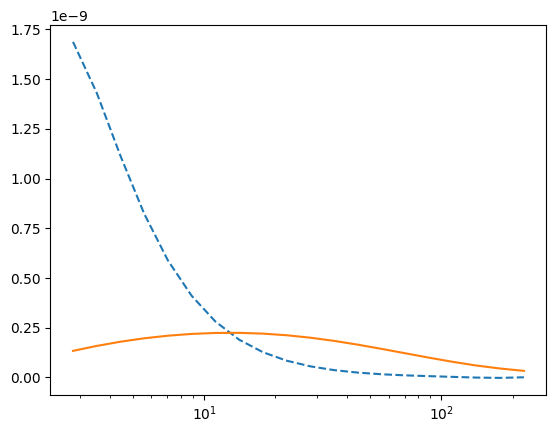

In [41]:
# get_power_BCMP_test.p_logc_Mz.shape
pl.figure()
pl.plot(get_corrfunc_BCMP_test.angles_data_array, get_corrfunc_BCMP_test.gty_1h_out_mat[:,3], ls='--')
pl.plot(get_corrfunc_BCMP_test.angles_data_array, get_corrfunc_BCMP_test.gty_2h_out_mat[:,3], ls='-')
pl.xscale('log')
# pl.xlim(0.8,100)
# pl.ylim(0.0,2e-9)
# pl.yscale('log')




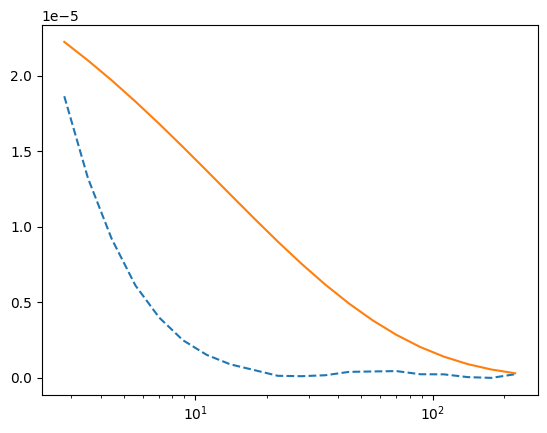

In [42]:
# get_power_BCMP_test.p_logc_Mz.shape
pl.figure()
pl.plot(get_corrfunc_BCMP_test.angles_data_array, get_corrfunc_BCMP_test.xip_1h_out_mat[:,3,3], ls='--')
pl.plot(get_corrfunc_BCMP_test.angles_data_array, get_corrfunc_BCMP_test.xip_2h_out_mat[:,3,3], ls='-')
pl.xscale('log')
# pl.xlim(0.8,100)
# pl.ylim(0.0,2e-4)
# pl.yscale('log')




In [157]:
# get_corrfunc_BCMP_test.theta_out_arcmin

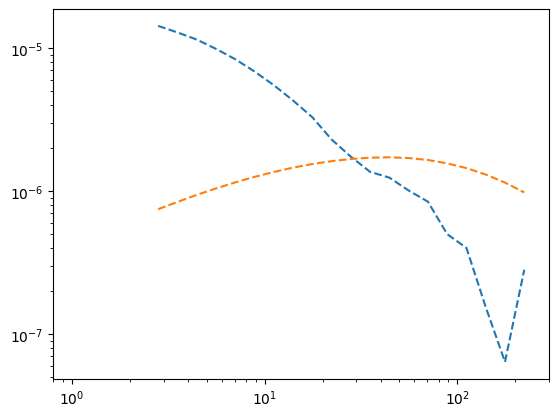

In [45]:
# get_power_BCMP_test.p_logc_Mz.shape
pl.figure()
pl.plot(get_corrfunc_BCMP_test.angles_data_array, get_corrfunc_BCMP_test.xim_1h_out_mat[:,3,3], ls='--')
pl.plot(get_corrfunc_BCMP_test.angles_data_array, get_corrfunc_BCMP_test.xim_2h_out_mat[:,3,3], ls='--')
pl.xscale('log')
pl.xlim(0.8,300)
# pl.ylim(0.0,2e-5)
pl.yscale('log')




In [46]:
# check if all the elements are finite
# np.all(np.isfinite(setup_power_BCMP_test.uk_dmb)), np.all(np.isfinite(setup_power_BCMP_test.uk_nfw))


In [47]:
# check if all the elements are finite
# np.all(np.isfinite(setup_power_BCMP_test.uyl_mat))
# get_power_BCMP_obj_test.Cl_kappa_y_1h_mat


In [48]:
# pl.figure()
# pl.plot(get_power_BCMP_obj_test.ell_array, get_power_BCMP_obj_test.Cl_kappa_y_1h_mat[3,:], ls='--')
# pl.plot(get_power_BCMP_obj_test.ell_array, get_power_BCMP_obj_test.Cl_kappa_y_2h_mat[3,:], ls='-')
# pl.xlim(32, 8096)
# # pl.ylim(1e-19, 5e-13)
# # pl.plot(get_power_BCMP_test.ell_array, (get_power_BCMP_test.ell_array**3) * (get_power_BCMP_test.Cl_kappa_y_1h_mat[3,:] + get_power_BCMP_test.Cl_kappa_y_2h_mat[3,:]), ls='-') 
# pl.xscale('log')
# pl.yscale('log')




In [49]:
# pl.figure()
# pl.plot(get_power_BCMP_obj_test.ell_array, get_power_BCMP_obj_test.Cl_kappa_kappa_1h_mat[3,3,:] + get_power_BCMP_obj_test.Cl_kappa_kappa_2h_mat[3,3,:], ls='--')
# pl.plot(get_power_BCMP_obj_test.ell_array, get_power_BCMP_obj_test.Cl_kappa_kappa_nfw_1h_mat[3,3,:] + get_power_BCMP_obj_test.Cl_kappa_kappa_2h_mat[3,3,:], ls='-')
# pl.xlim(32, 8096)
# # pl.ylim(1e-19, 5e-13)
# # pl.plot(get_power_BCMP_test.ell_array, (get_power_BCMP_test.ell_array**3) * (get_power_BCMP_test.Cl_kappa_y_1h_mat[3,:] + get_power_BCMP_test.Cl_kappa_y_2h_mat[3,:]), ls='-') 
# pl.xscale('log')
# pl.yscale('log')




In [50]:
C = jnp.array(df_data['COVMAT'].data[400:,400:])
data_vec = jnp.array(df_data['compton_shear'].data['VALUE'])
gty_data_to_plot = data_vec[60:]
gty_sig_to_plot = jnp.sqrt(jnp.diag(C))[60:]



In [51]:
C = jnp.array(df_data['COVMAT'].data[:200,:200])
data_vec = jnp.array(df_data['xip'].data['VALUE'])
bin1, bin2 = df_data['xip'].data['BIN1'], df_data['xip'].data['BIN2']
indsel = np.where((bin1==4) & (bin2==4))[0]
xip_data_to_plot = data_vec[indsel]
xip_sig_to_plot = jnp.sqrt(jnp.diag(C))[indsel]



In [52]:
C = jnp.array(df_data['COVMAT'].data[200:400,200:400])
data_vec = jnp.array(df_data['xim'].data['VALUE'])
bin1, bin2 = df_data['xim'].data['BIN1'], df_data['xim'].data['BIN2']
indsel = np.where((bin1==4) & (bin2==4))[0]
xim_data_to_plot = data_vec[indsel]
xim_sig_to_plot = jnp.sqrt(jnp.diag(C))[indsel]



Text(0.5, 0, '$\\theta$ (arcmin)')

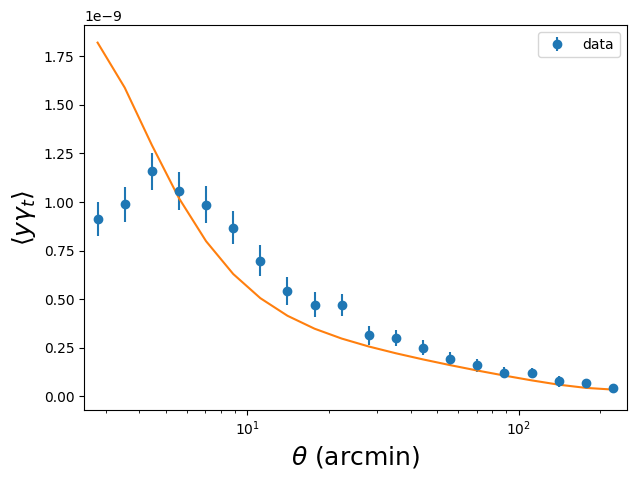

In [54]:
pl.figure(figsize=(7,5))
# pl.subplot(131)
pl.errorbar(analysis_dict['angles_data_array'], gty_data_to_plot, yerr=gty_sig_to_plot, fmt='o', label='data')
# for jt in range(len(theta_ej_all)):
pl.plot(analysis_dict['angles_data_array'], get_corrfunc_BCMP_test.gty_out_mat[:,3])
pl.legend()
pl.xscale('log')
pl.xlim(2.5,250)
# pl.ylim(0.0,2e-9)
# pl.title(r'Variation of $\theta_{ej}$')
pl.ylabel(r'$\langle y \gamma_t \rangle$', size=18)
pl.xlabel(r'$\theta$ (arcmin)', size=18)


In [55]:
get_corrfunc_BCMP_test.xip_out_mat.shape

(20, 4, 4)

Text(0.5, 0, '$\\theta$ (arcmin)')

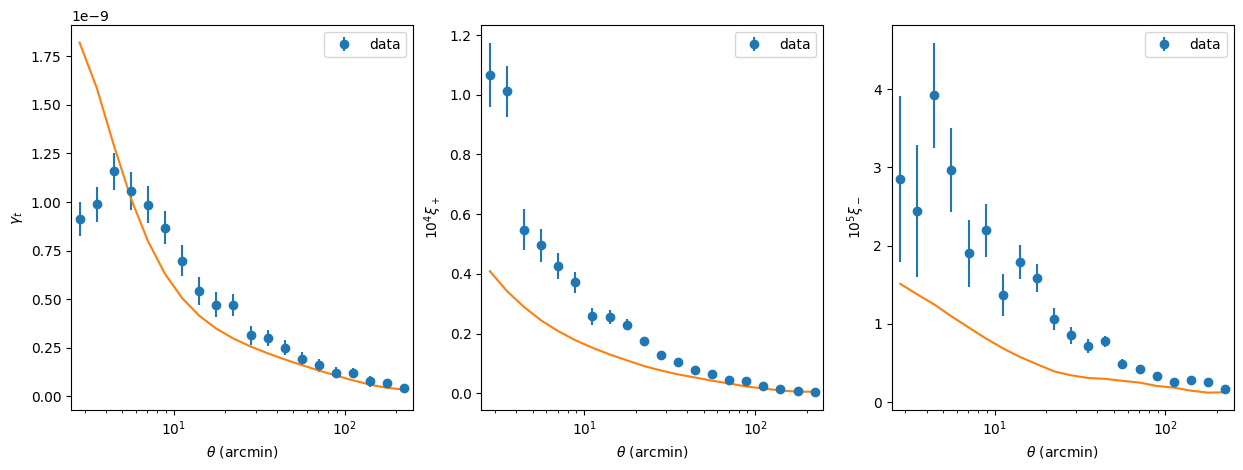

In [57]:
# make a three panel plot, plotting all the theta_ej curves for for gty_out_thetaej[:,3,:], xip_out_thetaej[:,3,3,:], xim_out_thetaej[:,3,3,:]
# draw theta_ej curves from a colormap

pl.figure(figsize=(15,5))
pl.subplot(131)
pl.errorbar(analysis_dict['angles_data_array'], gty_data_to_plot, yerr=gty_sig_to_plot, fmt='o', label='data')
pl.plot(analysis_dict['angles_data_array'], get_corrfunc_BCMP_test.gty_out_mat[:,3])
pl.legend()
pl.xscale('log')
pl.xlim(2.5,250)
# pl.ylim(0.0,2e-9)
pl.ylabel(r'$\gamma_t$')
pl.xlabel(r'$\theta$ (arcmin)')
# pl.title('1-halo term')
pl.subplot(132)
pl.errorbar(analysis_dict['angles_data_array'], 1e4*xip_data_to_plot, yerr=1e4*xip_sig_to_plot, fmt='o', label='data')
pl.plot(analysis_dict['angles_data_array'], 1e4*get_corrfunc_BCMP_test.xip_out_mat[:,3,3])
pl.legend()
pl.xscale('log')
pl.xlim(2.5,250)
# pl.ylim(0.0,2e-9)
pl.ylabel(r'$10^4 \xi_+$')
pl.xlabel(r'$\theta$ (arcmin)')
# pl.title('2-halo term')
pl.subplot(133)
pl.errorbar(analysis_dict['angles_data_array'], 1e5*xim_data_to_plot, yerr=1e5*xim_sig_to_plot, fmt='o', label='data')
pl.plot(analysis_dict['angles_data_array'], 1e5*get_corrfunc_BCMP_test.xim_out_mat[:,3,3])
pl.legend()
pl.legend()
pl.xscale('log')
pl.xlim(2.5,250)
# pl.ylim(0.0,2e-9)
pl.ylabel(r'$10^5 \xi_-$')
pl.xlabel(r'$\theta$ (arcmin)')
# pl.title('2-halo term')






In [138]:
analysis_dict['angles_data_array']

Array([  2.80504614,   3.53134386,   4.44569853,   5.59680285,
         7.04595733,   8.87033473,  11.1670898 ,  14.05853313,
        17.69864461,  22.28127345,  28.05046136,  35.31343862,
        44.45698525,  55.96802846,  70.45957328,  88.70334731,
       111.67089804, 140.5853313 , 176.9864461 , 222.81273453],      dtype=float64)

In [52]:
# from colossus.lss import bias
# bM = bias.haloBias(setup_power_BCMP_test.M_array, 0.0, mdef='200c', model='tinker10')

# # dndm_jax.shape
# pl.figure()
# pl.plot(setup_power_BCMP_test.M_array, setup_power_BCMP_test.bias_Mz_mat[0,:])
# pl.plot(setup_power_BCMP_test.M_array, bM, ls='--')
# pl.xscale('log')
# # pl.yscale('log')





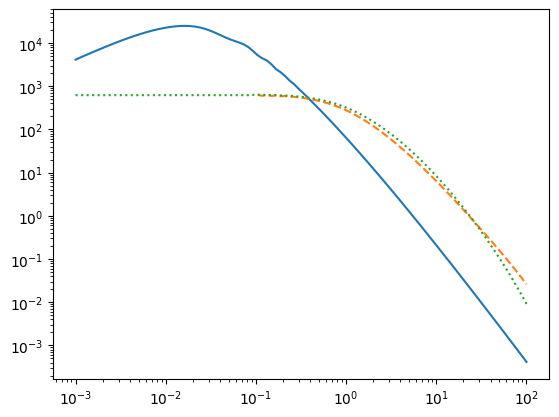

In [71]:
pl.figure()
pl.plot(setup_power_BCMP_test.kPk_array, setup_power_BCMP_test.plin_kz_mat[:,0])
pl.plot(setup_power_BCMP_test.kPk_array, setup_power_BCMP_test.Pmm_dmb_1h_mat[:,0], ls='--')
pl.plot(setup_power_BCMP_test.kPk_array, setup_power_BCMP_test.Pmm_nfw_1h_mat[:,0], ls=':')
pl.xscale('log')
pl.yscale('log')



(0.69, 1.5)

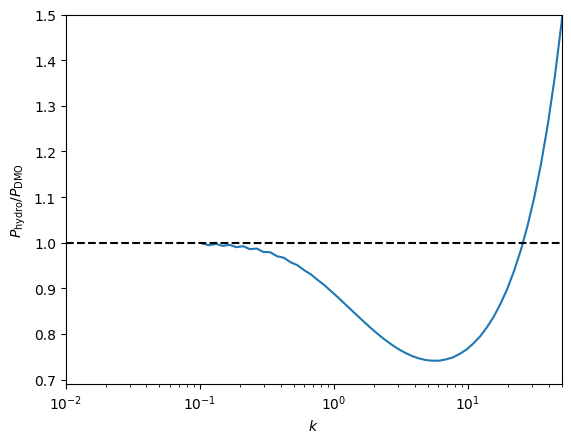

In [72]:
Pk_nfw = setup_power_BCMP_test.plin_kz_mat[:,0] + setup_power_BCMP_test.Pmm_nfw_1h_mat[:,0]
Pk_dmb = setup_power_BCMP_test.plin_kz_mat[:,0] + setup_power_BCMP_test.Pmm_dmb_1h_mat[:,0]
pl.figure()
pl.plot(setup_power_BCMP_test.kPk_array, (Pk_dmb)/Pk_nfw)
pl.xscale('log')
pl.axhline(1.0, color='k', ls='--')
pl.xlim(1e-2, 50)
pl.xlabel(r'$k$')
pl.ylabel(r'$P_{\rm hydro}/P_{\rm DMO}$')
pl.ylim(0.69,1.5)
# pl.yscale('log')




In [157]:
# setup_power_BCMP_test.Pmm_dmb_1h_mat.shape
# setup_power_BCMP_test.kPk_array
# setup_power_BCMP_test.uk_nfw_Pk[:,0,0,0]
# setup_power_BCMP_test.uk_dmb_Pk[:,0,0,0]
setup_power_BCMP_test.uk_dmb[:,0,0,0]
# (Pk_dmb)
# Pk_nfw

Array([-4.00917588e+01,  3.15555364e+01, -2.16192225e+01,  1.77459096e+01,
       -1.13110086e+01,  1.00646361e+01, -5.59863161e+00,  5.82615607e+00,
       -2.46205120e+00,  3.51198095e+00, -7.60692354e-01,  2.26615259e+00,
        1.47099797e-01,  1.60821567e+00,  6.20517368e-01,  1.26999674e+00,
        8.59309159e-01,  1.10289208e+00,  9.73576649e-01,  1.02530177e+00,
        1.02326095e+00,  9.92894412e-01,  1.04037961e+00,  9.81820950e-01,
        1.04144753e+00,  9.79233196e-01,  1.03430317e+00,  9.77881133e-01,
        1.02173048e+00,  9.72954473e-01,  1.00324800e+00,  9.60173240e-01,
        9.75929867e-01,  9.34720194e-01,  9.34983657e-01,  8.91115466e-01,
        8.74892490e-01,  8.24497564e-01,  7.91847864e-01,  7.33499282e-01,
        6.87197189e-01,  6.23330663e-01,  5.69473224e-01,  5.05703063e-01,
        4.51729914e-01,  3.93745303e-01,  3.45207093e-01,  2.96172389e-01,
        2.55588807e-01,  2.16272309e-01,  1.84131210e-01,  1.53955105e-01,
        1.29576529e-01,  

In [156]:
setup_power_BCMP_test.k

Array([8.54534660e-03, 1.00000000e-02, 1.17022755e-02, 1.36943251e-02,
       1.60254765e-02, 1.87534541e-02, 2.19458086e-02, 2.56815898e-02,
       3.00533038e-02, 3.51692040e-02, 4.11559714e-02, 4.81618515e-02,
       5.63603253e-02, 6.59544053e-02, 7.71816620e-02, 9.03201070e-02,
       1.05695077e-01, 1.23687291e-01, 1.44742275e-01, 1.69381398e-01,
       1.98214778e-01, 2.31956394e-01, 2.71441762e-01, 3.17648627e-01,
       3.71721174e-01, 4.34998358e-01, 5.09047061e-01, 5.95700894e-01,
       6.97105597e-01, 8.15772173e-01, 9.54639070e-01, 1.11714494e+00,
       1.30731378e+00, 1.52985460e+00, 1.79027800e+00, 2.09503263e+00,
       2.45166490e+00, 2.86900580e+00, 3.35738962e+00, 3.92890982e+00,
       4.59771851e+00, 5.38037685e+00, 6.29626521e+00, 7.36806300e+00,
       8.62231029e+00, 1.00900650e+01, 1.18076721e+01, 1.38176631e+01,
       1.61698100e+01, 1.89223571e+01, 2.21434636e+01, 2.59128911e+01,
       3.03239790e+01, 3.54859556e+01, 4.15266428e+01, 4.85956213e+01,
      

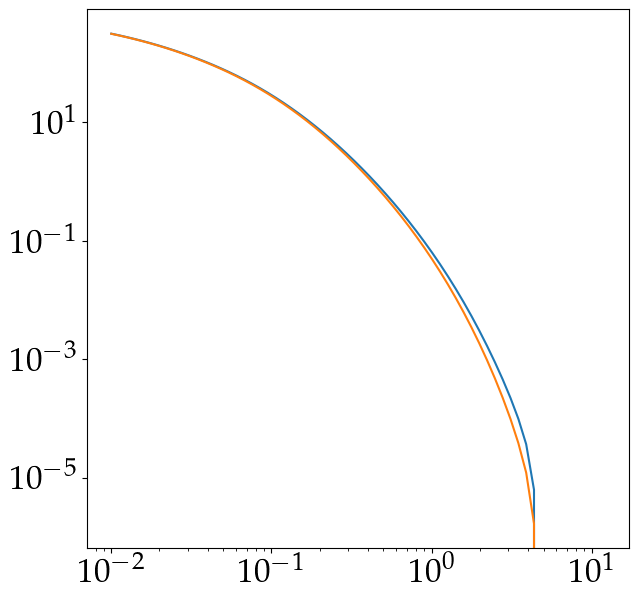

In [63]:
# Ptot_mat.shape
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline

pl.figure()
pl.plot(BCMP_test.r_array, BCMP_test.Ptot_mat[:,0,0,0])
pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,0,0,0])
pl.xscale('log')
pl.yscale('log')
pl.show()




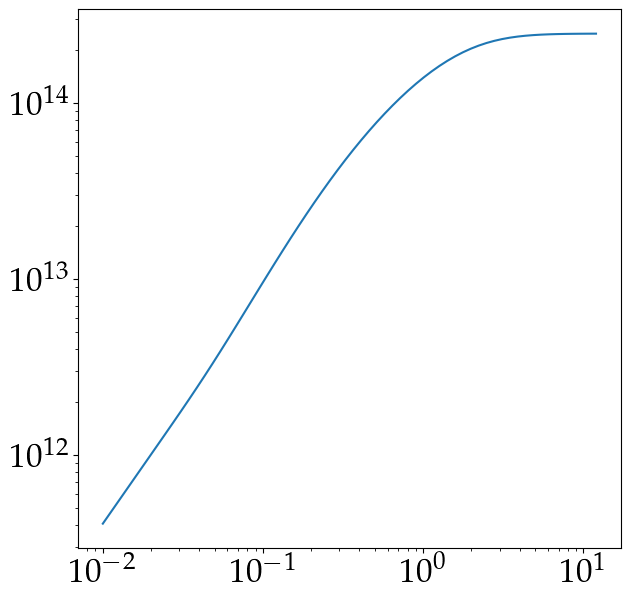

In [64]:
# Ptot_mat.shape
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline

pl.figure()
pl.plot(BCMP_test.r_array, BCMP_test.Mdmb_mat[:,0,0,0])
# pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,0,0,0])
pl.xscale('log')
pl.yscale('log')
pl.show()




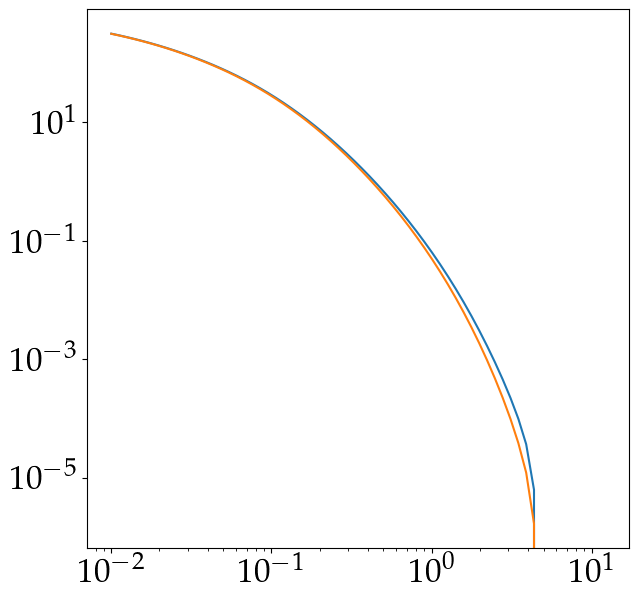

In [65]:
# Ptot_mat.shape
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline

pl.figure()
pl.plot(BCMP_test.r_array, BCMP_test.Ptot_mat[:,0,0,0])
pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,0,0,0])
pl.xscale('log')
pl.yscale('log')
pl.show()




In [66]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_gas_normed, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_gas_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 222 ms, sys: 0 ns, total: 222 ms
Wall time: 171 ms


In [67]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_clm, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_clm_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 759 ms, sys: 16.4 ms, total: 775 ms
Wall time: 422 ms


In [68]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_cga, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_cga_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 236 ms, sys: 0 ns, total: 236 ms
Wall time: 153 ms


In [69]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_dmb, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_dmb_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 922 ms, sys: 36.1 ms, total: 959 ms
Wall time: 543 ms


In [94]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_nfw_normed, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_nfw_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 153 ms, sys: 4.86 ms, total: 158 ms
Wall time: 196 ms


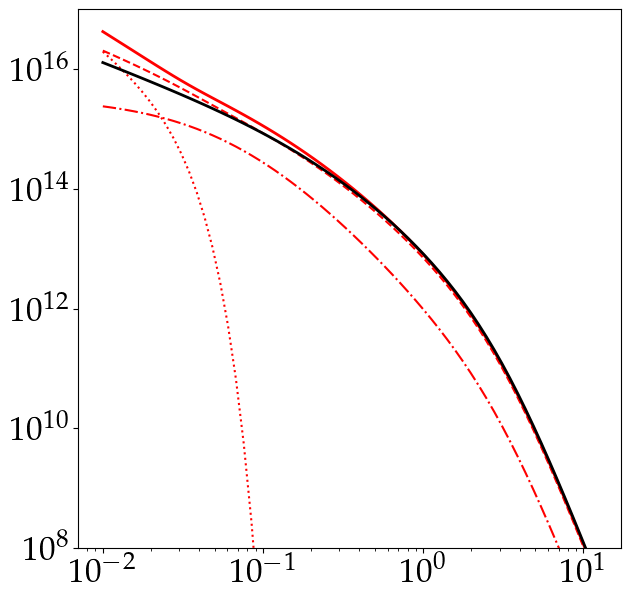

In [71]:
pl.figure()
pl.plot(BCMP_test.r_array, rho_gas_normed_mat[:,0,0,0], ls='-.', color='r')
pl.plot(BCMP_test.r_array, rho_clm_normed_mat[:,0,0,0], ls='--', color='r')
pl.plot(BCMP_test.r_array, rho_cga_normed_mat[:,0,0,0], ls=':', color='r')
pl.plot(BCMP_test.r_array, rho_dmb_normed_mat[:,0,0,0], ls='-', color='r', lw=2)
pl.plot(BCMP_test.r_array, rho_nfw_normed_mat[:,0,0,0], ls='-', color='k', lw=2)
pl.xscale('log')
pl.yscale('log')
pl.ylim(1e8, 1e17)
pl.show()






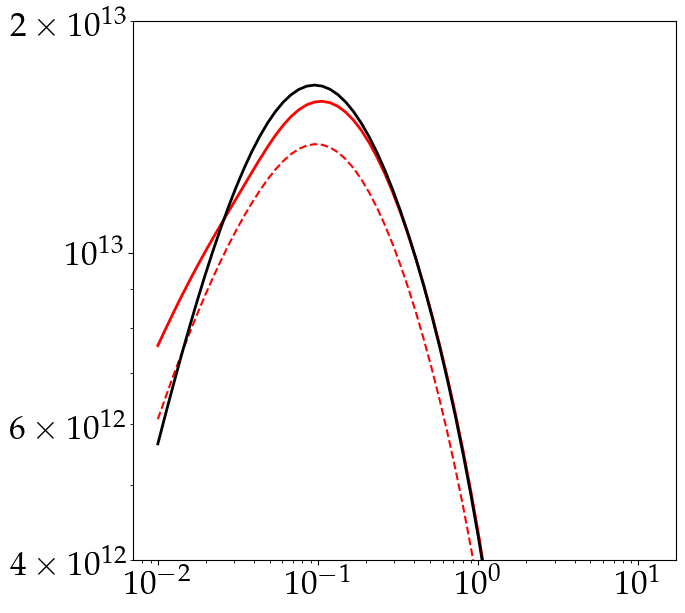

In [77]:
pl.figure()
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_gas_normed_mat[:,-5,0,0], ls='-.', color='r')
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_clm_normed_mat[:,-5,0,0], ls='--', color='r')
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_cga_normed_mat[:,-5,0,0], ls=':', color='r')
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_dmb_normed_mat[:,-5,0,0], ls='-', color='r', lw=2)
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_nfw_normed_mat[:,-5,0,0], ls='-', color='k', lw=2)
pl.xscale('log')
pl.yscale('log')
pl.ylim(4e12,2e13)
# pl.ylim(1e8, 1e17)
pl.show()






In [91]:
# BCMP_test.conc_array[-5]
from mcfit import xi2P


In [104]:
Mtot_rep = jnp.repeat(BCMP_test.Mtot_mat[None, :, :, :], len(BCMP_test.r_array), axis=0)


In [103]:
BCMP_test.Mtot_mat.shape


(16, 64, 64)

In [109]:
k, P_nfw = xi2P(BCMP_test.r_array)(BCMP_test.rho_nfw_mat/Mnfw_rep, axis=0)



In [108]:
k, P_dmb = xi2P(BCMP_test.r_array)(BCMP_test.rho_dmb_mat/Mnfw_rep, axis=0)



In [128]:
window = jnp.ones(5) / 5
y_smooth = jnp.convolve(P_nfw[:,-5,0,0], window, mode='same')



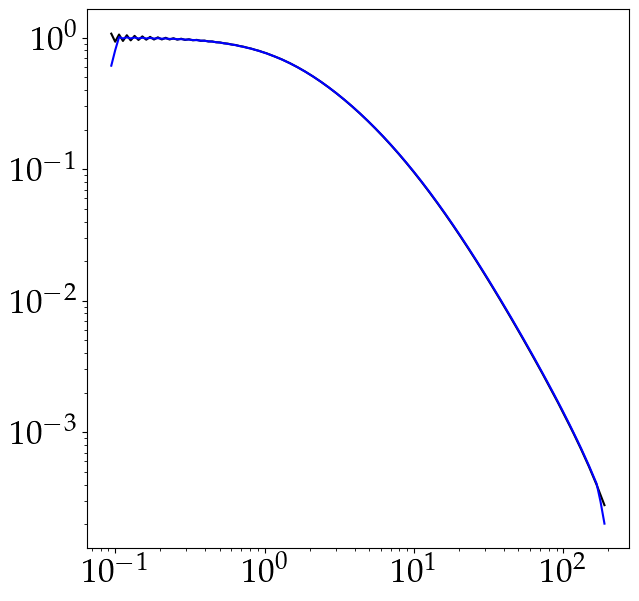

In [131]:
pl.figure()
indc = 3
window = jnp.ones(5) / 5
# pl.plot(k, (k**3) * P_nfw[:,indc,0,0], color='k')
# pl.plot(k, (k**3) * jnp.convolve(P_nfw[:,indc,0,0], window, mode='same'), color='b')
pl.plot(k, P_nfw[:,indc,0,0], color='k')
pl.plot(k, jnp.convolve(P_nfw[:,indc,0,0], window, mode='same'), color='b')

pl.xscale('log')
pl.yscale('log')




In [ ]:
from jax_cosmo.power import sigmasqr

